# 🤪 변이형 오토인코더 - CelebA Faces

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py와 vae_utils.py, download_kaggle_data.sh를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/03_vae/03_vae_faces/vae_utils.py
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/scripts/downloaders/download_kaggle_data.sh

--2023-05-17 06:11:54--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-17 06:11:54 (30.9 MB/s) - ‘utils.py’ saved [771/771]

--2023-05-17 06:11:54--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/03_vae/03_vae_faces/vae_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

이 노트북에서는 CelebA 얼굴 데이터셋으로 변이형 오토인코더를 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from notebooks.utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # 캐글-->Setttings-->API-->Create New Token에서 
    # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    !kaggle datasets download -d jessicali9530/celeba-dataset
    !unzip -q celeba-dataset.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Saving kaggle.json to kaggle.json
100% 1.33G/1.33G [00:59<00:00, 25.1MB/s]
100% 1.33G/1.33G [00:59<00:00, 24.0MB/s]


In [6]:
# 데이터 로드
train_data = utils.image_dataset_from_directory(
    "./img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [7]:
# 데이터 전처리
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

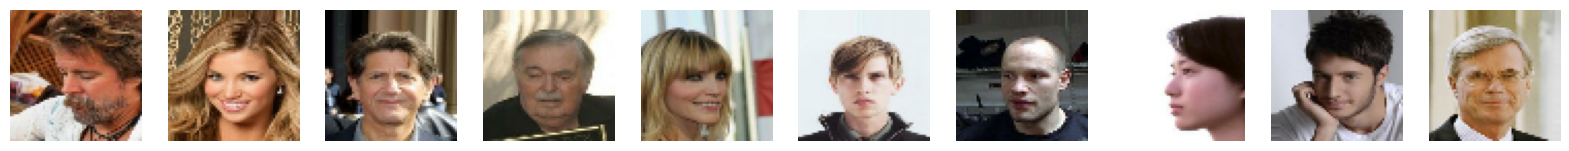

In [9]:
# 훈련 세트의 일부 얼굴 표시
display(train_sample, cmap=None)

## 2. 변이형 오토인코더 만들기 <a name="build"></a>

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [12]:
# 디코더
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                     

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """검증 스텝을 실행합니다."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

## 3. 변이형 오토인코더 훈련하기 <a name="train"></a>

In [15]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [17]:
# 필요한 경우 이전 가중치 로드
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [20]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
   6/1583 [..............................] - ETA: 2:02 - loss: 73.2208 - reconstruction_loss: 57.7908 - kl_loss: 14.5256

1582/1583 [============================>.] - ETA: 0s - loss: 71.1035 - reconstruction_loss: 54.7204 - kl_loss: 15.3050

1583/1583 [==============================] - 116s 73ms/step - loss: 71.1021 - reconstruction_loss: 54.7199 - kl_loss: 15.3053
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 68.2769 - reconstruction_loss: 51.9366 - kl_loss: 15.9323

1583/1583 [==============================] - 107s 68ms/step - loss: 68.2767 - reconstruction_loss: 51.9366 - kl_loss: 15.9323
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 66.8502 - reconstruction_loss: 50.3252 - kl_loss: 16.2905

1583/1583 [==============================] - 108s 68ms/step - loss: 66.8500 - reconstruction_loss: 50.3252 - kl_loss: 16.2905
Epoch 4/10
1582/1583 [============================>.] - ETA: 0s - loss: 66.0883 - reconstruction_loss: 49.2885 - kl_loss: 16.5818

1583/1583 [==============================] - 108s 68ms/step - loss: 66.0880 - reconstruction_loss: 49.2916 - kl_loss: 16.5818
Epoch 5/10
1582/1583 [============================>.] - ETA: 0s - loss: 65.4560 - reconstruction_loss: 48.4513 - kl_loss: 16.7950

1583/1583 [==============================] - 109s 69ms/step - loss: 65.4558 - reconstruction_loss: 48.4512 - kl_loss: 16.7952
Epoch 6/10
1582/1583 [============================>.] - ETA: 0s - loss: 65.0310 - reconstruction_loss: 48.0426 - kl_loss: 16.8690

1583/1583 [==============================] - 108s 68ms/step - loss: 65.0308 - reconstruction_loss: 48.0423 - kl_loss: 16.8691
Epoch 7/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.8199 - reconstruction_loss: 47.7891 - kl_loss: 16.9188

1583/1583 [==============================] - 107s 67ms/step - loss: 64.8198 - reconstruction_loss: 47.7889 - kl_loss: 16.9186
Epoch 8/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.5917 - reconstruction_loss: 47.5498 - kl_loss: 16.9506

1583/1583 [==============================] - 108s 68ms/step - loss: 64.5916 - reconstruction_loss: 47.5529 - kl_loss: 16.9511
Epoch 9/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.4032 - reconstruction_loss: 47.2993 - kl_loss: 17.0250

1583/1583 [==============================] - 108s 68ms/step - loss: 64.4031 - reconstruction_loss: 47.2998 - kl_loss: 17.0247
Epoch 10/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.2691 - reconstruction_loss: 47.0641 - kl_loss: 17.1149

1583/1583 [==============================] - 108s 68ms/step - loss: 64.2689 - reconstruction_loss: 47.0663 - kl_loss: 17.1150


In [21]:
# 최종 모델 저장
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. 변이형 오토인코더를 사용한 재구성 <a name="reconstruct"></a>

In [22]:
# 테스트 세트에서 일부분을 선택합니다.
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 7ms/step
실제 얼굴


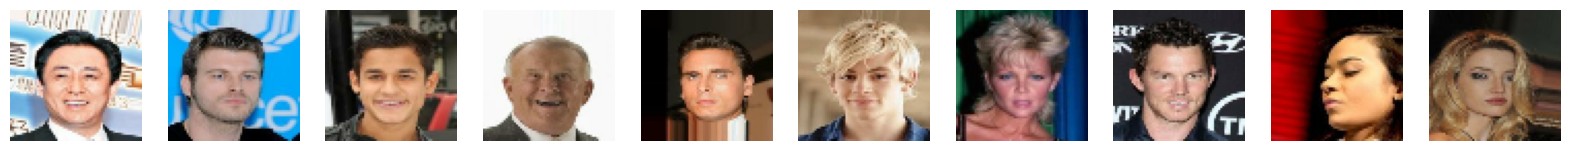

재구성


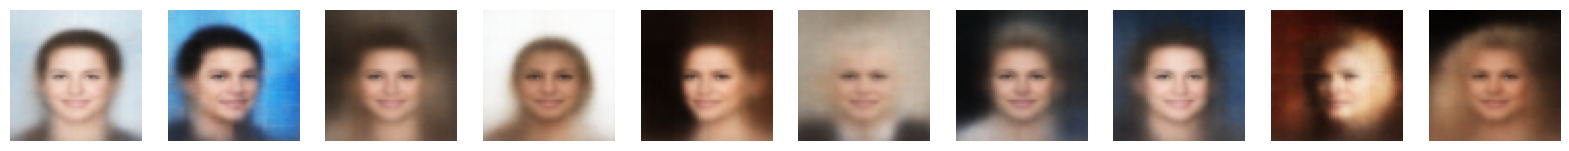

In [23]:
# 오토인코더 예측을 생성하고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 얼굴")
display(example_images)
print("재구성")
display(reconstructions)

## 4. 잠재 공간 분포

4/4 [==============================] - 0s 5ms/step


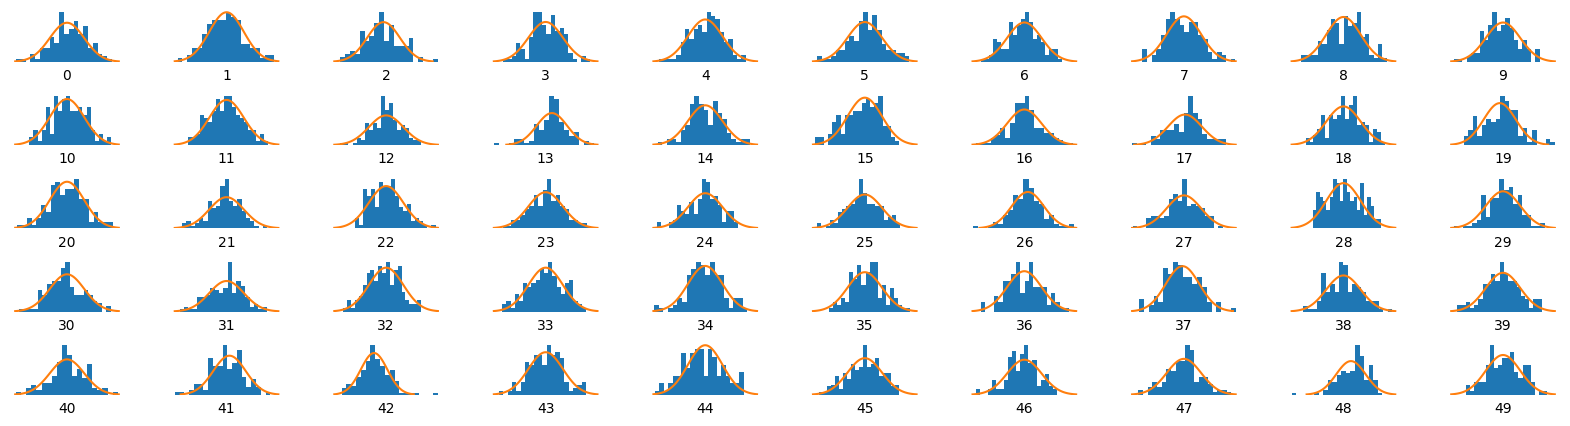

In [24]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. 새로운 얼굴 생성 <a name="decode"></a>

In [25]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [26]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 471ms/step


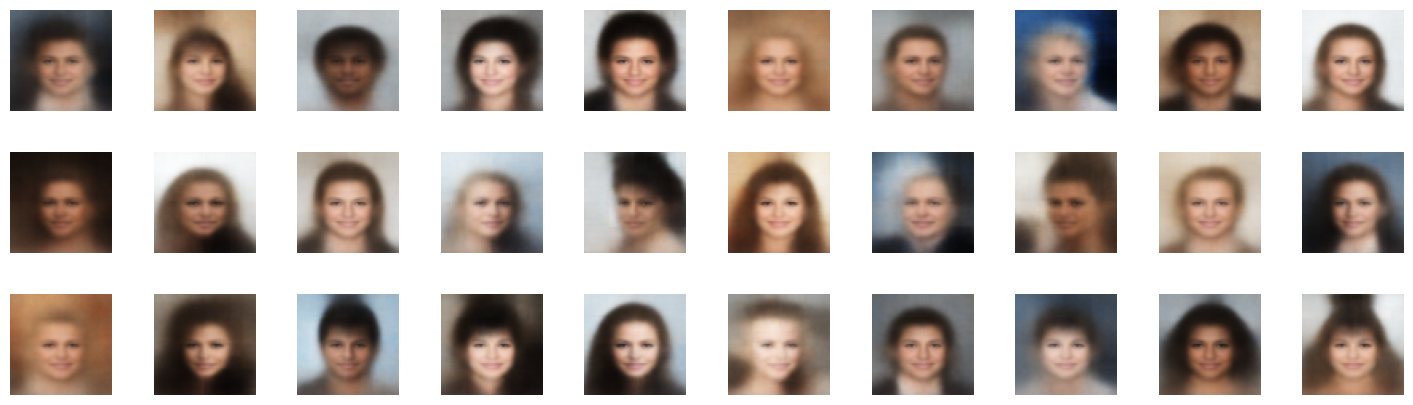

In [27]:
# 디코딩된 이미지의 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. 이미지 조작 <a name="manipulate"></a>

In [29]:
# 레이블 데이터셋 로드
attributes = pd.read_csv("./list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [31]:
# 레이블이 부착된 얼굴 데이터 로드
LABEL = "Blond_Hair"  # <- 이 레이블 설정
labelled_test = utils.image_dataset_from_directory(
    "./img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [32]:
# 속성 벡터 찾기
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.166    : 1.49    : 3.568    : 3.568
44    : 2.116    : 0.925    : 2.806    : -0.762
65    : 1.116    : 0.533    : 2.502    : -0.304
87    : 0.842    : 0.413    : 2.179    : -0.322
110    : 0.681    : 0.296    : 1.99    : -0.19
128    : 0.485    : 0.253    : 1.949    : -0.04
150    : 0.481    : 0.216    : 1.895    : -0.054
171    : 0.419    : 0.19    : 1.856    : -0.039
197    : 0.366    : 0.174    : 1.803    : -0.053
218    : 0.33    : 0.13    : 1.776    : -0.026
241    : 0.283    : 0.127    : 1.742    : -0.034
260    : 0.246    : 0.114    : 1.726    : -0.016
282    : 0.241    : 0.108    : 1.694    : -0.032
302    : 0.218    : 0.097    : 1.648    : -0.047
317    : 0.179    : 0.104    : 1.636    : -0.012
337    : 0.178    : 0.095    : 1.634    : -0.002
356    : 0.166    : 0.085    : 1.603    : -0.03
377    : 0.176    : 0.078    : 1.591    : -0.012
395    : 0.167    : 0.072    : 1.562    : -0.029
415    : 0.1

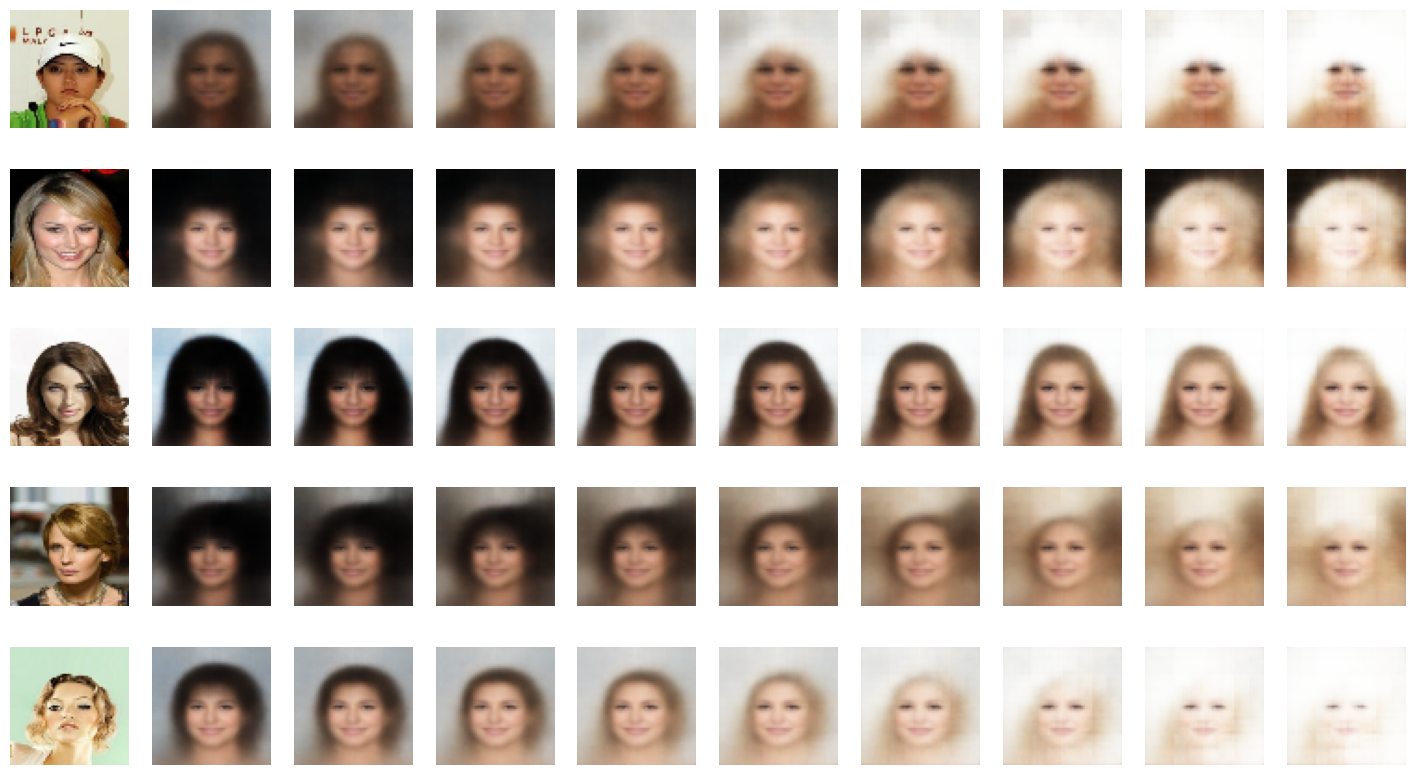

In [33]:
# 이미지에 벡터 추가
add_vector_to_images(labelled, vae, attribute_vec)

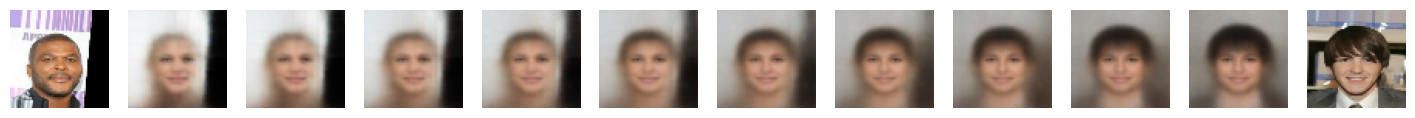

In [34]:
morph_faces(labelled, vae)